In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
pd.set_option('display.max_rows', 30)
!date

Thu Feb 20 14:37:50 PST 2020


# 2010 census demo data. Look minority/majority bias in prisons and elderly

In [26]:
sf_black_institionalized = ['PCT020B002']
sf_black_correctional = ['PCT020B003']
sf_black_correctional_children = ['PCT020B013']

dp_black_institutionalized = ['PCO043B004','PCO043B014','PCO043B024',
                              'PCO043B035','PCO043B045','PCO043B055',] #M<18, 18-64, 65+, F<18, 18-64, 65+

dp_black_correctional = ['PCO043B005','PCO043B015','PCO043B025',
                         'PCO043B036','PCO043B046','PCO043B056',] #M<18, 18-64, 65+, F<18, 18-64, 65+

sf_black_prisons = sf_black_institionalized + sf_black_correctional + sf_black_correctional_children
dp_black_prisons = dp_black_institutionalized + dp_black_correctional

In [27]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

aian_cols = ['P0030005','P0060004'] # AIAN alone, AIAN combo
elder = ['P0120025','PCT0120207','PCT0120208','PCT0120209'] #85+ years, 100-104, 105-109, 110+
prisons_black = sf_black_institionalized + sf_black_correctional + sf_black_correctional_children# + dp_black_institutionalized + dp_black_correctional 
keep_cols = location_cols + aian_cols + elder + prisons_black

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','TBLGRP','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [4]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 10min 54s, sys: 37.1 s, total: 11min 31s
Wall time: 13min 53s


In [38]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[19:] = [x.upper() for x in dta_columns[19:]] #coded vars are capitalized
dta_columns = dta_columns[:-12] + sf_black_prisons
dta_columns

['state',
 'county',
 'tract',
 'blkgrp',
 'block',
 'aianhh',
 'aianhhfp',
 'aianhhcc',
 'aitsce',
 'aits',
 'aitscc',
 'ttract',
 'ua',
 'uasc',
 'uatype',
 'ur',
 'aianhhns',
 'aitsns',
 'aianhhsc',
 'P0010001',
 'P0030005',
 'P0060004',
 'P0120025',
 'PCT0120207',
 'PCT0120208',
 'PCT0120209',
 'PCT020B002',
 'PCT020B003',
 'PCT020B013']

In [ ]:
%%time

r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

df_sf = pd.DataFrame()
for t in r:
    print('.', flush=True, end=' ')
    df_sf = df_sf.append(t)

#saved AIAN-relevant vars here; loads faster than the .dta
# df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/institutionalized_black_census2010.csv')

. . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/institutionalized_black_census2010.csv', index = None, header=True)

In [30]:
# print(df_sf.columns)
print(df_sf.columns)
print(sf_black_prisons)

Index(['state', 'county', 'tract', 'blkgrp', 'block', 'aianhh', 'aianhhfp',
       'aianhhcc', 'aitsce', 'aits', 'aitscc', 'ttract', 'ua', 'uasc',
       'uatype', 'ur', 'aianhhns', 'aitsns', 'aianhhsc', 'P0010001',
       'P0030005', 'P0060004', 'P0120025', 'PCT0120207', 'PCT0120208',
       'PCT0120209'],
      dtype='object')
['PCT020B002', 'PCT020B003', 'PCT020B013']


In [29]:
df_sf.columns = [x.upper() for x in df_sf.columns]

In [ ]:
#store columns by type
float_cols = list(df_dp.loc[:, df_dp.dtypes == np.float64].columns)
int_cols = df_dp.loc[:, df_dp.dtypes == np.int64].columns

#conver df_sf to correct dtypes
df_sf.loc[:,float_cols] = df_sf.loc[:,float_cols].astype(np.float64)
df_sf.loc[:,int_cols] = df_sf.loc[:,int_cols].astype(np.int64)

#check
df_sf.dtypes

In [ ]:
count_vars = list(df_sf.columns[[x.startswith("P0") for x in df_sf.columns]])
df_sf[count_vars].head

In [ ]:
left = df_sf[keep_cols + ['P0010001']]
df = pd.merge(left[(left.BLOCK != '')], df_dp.dropna(subset=['BLOCK']), left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'))
df

In [16]:
count_vars_sfdp = [s + "_SF" for s in count_vars]+[s + "_DP" for s in count_vars]
tract_df = df.groupby(['STATE','COUNTY','TRACT'])[count_vars_sfdp].apply(lambda x : x.astype(int).sum())
tract_df.head()

P0010001_SF  P0030003_SF  P0030005_SF  P0060003_SF  \
STATE COUNTY TRACT                                                         
1     1.0    20100.0         1912          217           14          229   
             20200.0         2170         1217            5         1229   
             20300.0         3373          647           17          672   
             20400.0         4386          193           18          209   
             20500.0        10766         1437          296         1526   

                      P0060004_SF  P0120025_SF  P0010001_DP  P0030003_DP  \
STATE COUNTY TRACT                                                         
1     1.0    20100.0           25            6         1970          220   
             20200.0           11            7         2210         1231   
             20300.0           38           13         3358          653   
             20400.0           36           21         4368          219   
             20500.0          109           28        10723         1413   

                      P0030005_DP  P0060003_DP  P0060004_DP  P0120025_DP  
STATE COUNTY TRACT                                                        
1     1.0    20100.0            0          239           57            0  
             20200.0           11         1265           25            2  
             20300.0            6          683           48           56  
             20400.0           23          241           28           47  
             20500.0          315         1507          102           12

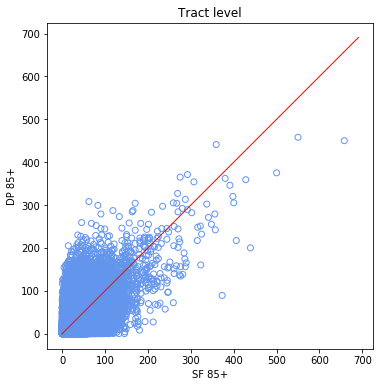

In [17]:
#old v new
x = tract_df[["P0120025_SF"]]
y = tract_df[["P0120025_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF 85+')
plt.ylabel('DP 85+')
plt.title('Tract level')

plt.show()

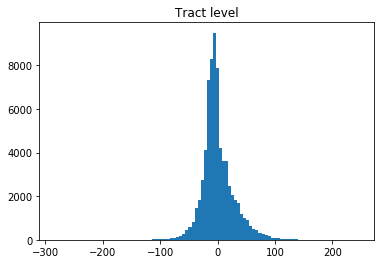

In [18]:
tract_df[['P0120025_SF','P0120025_DP']].describe()
tract_df['abs_diff_age'] = tract_df['P0120025_DP'] - tract_df['P0120025_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(tract_df[(tract_df.P0120025_DP!=0) | (tract_df.P0120025_SF!=0)].abs_diff_age, bins = 100)

plt.title('Tract level')

plt.show()

In [19]:
county_level = df.groupby(['STATE','COUNTY',])[count_vars_sfdp].apply(lambda x : x.astype(int).sum())

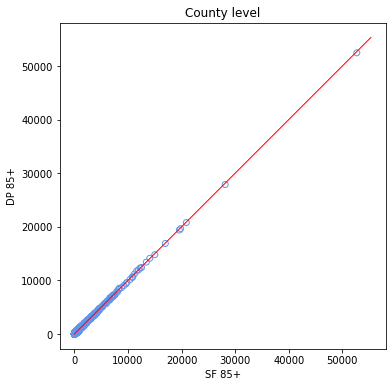

In [20]:
#old v new
x = county_level[["P0120025_SF"]]
y = county_level[["P0120025_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF 85+')
plt.ylabel('DP 85+')
plt.title('County level')

plt.show()

In [21]:
urban_elderly = df[df.UR=='U'].copy(deep=True)

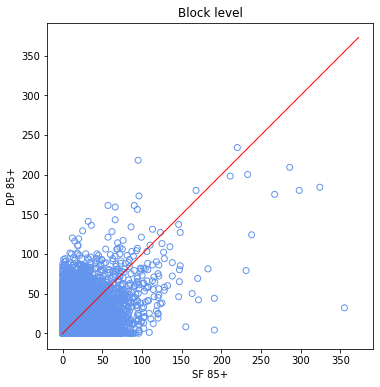

In [22]:
#old v new
x = urban_elderly[["P0120025_SF"]]
y = urban_elderly[["P0120025_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF 85+')
plt.ylabel('DP 85+')
plt.title('Block level')

plt.show()

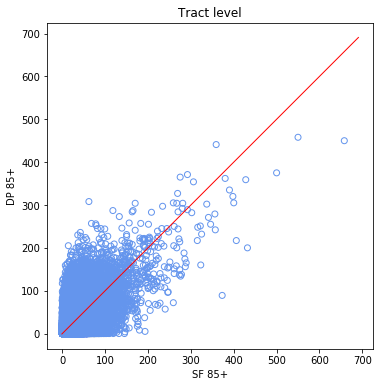

In [23]:
ur_el_tract = urban_elderly.groupby(['STATE','COUNTY','TRACT'])[count_vars_sfdp].apply(lambda x : x.astype(int).sum())

#old v new
x = ur_el_tract[["P0120025_SF"]]
y = ur_el_tract[["P0120025_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF 85+')
plt.ylabel('DP 85+')
plt.title('Tract level')

plt.show()

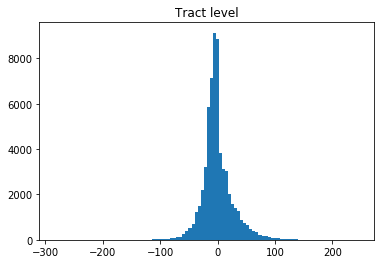

In [24]:
ur_el_tract['abs_diff_age'] = ur_el_tract['P0120025_DP'] - ur_el_tract['P0120025_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(ur_el_tract[(ur_el_tract.P0120025_DP!=0) | (ur_el_tract.P0120025_SF!=0)].abs_diff_age, bins = 100)

plt.title('Tract level')

plt.show()

In [26]:
ur_el_tract.abs_diff_age.describe()

count    64676.000000
mean        -0.811244
std         26.282572
min       -284.000000
25%        -14.000000
50%         -4.000000
75%          9.000000
max        246.000000
Name: abs_diff_age, dtype: float64

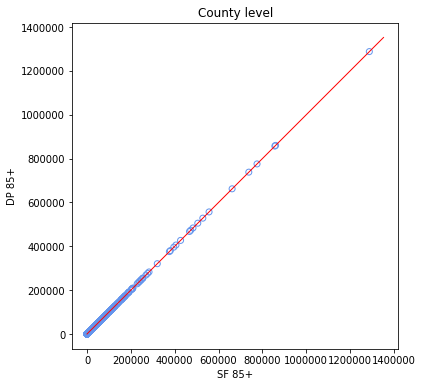

In [27]:
#old v new, black alone
x = county_level[["P0030003_SF"]]
y = county_level[["P0030003_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF 85+')
plt.ylabel('DP 85+')
plt.title('County level')

plt.show()

In [ ]:
#diff v size
urban_county["abs_diff_aian_combo"] = urban_county["P0060004_DP"] - urban_county["P0060004_SF"]

#check out AIAN in combo, county level counts change
x = urban_county[["P0060004_SF"]]
y = urban_county[["abs_diff_aian_combo"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN in combo count change')

plt.show()